Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

Warning! Using mpiexec in global path
Warning! Using python in global path


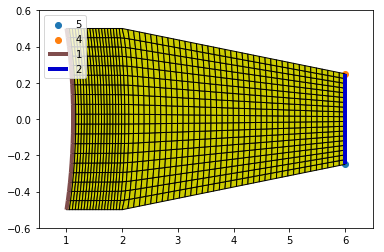

In [1]:
import amfe
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as linalg
from scipy.sparse import linalg as splinalg
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#%matplotlib notebook

mshfile = amfe.amfe_dir('meshes/test_meshes/2_partitions_quad_mesh.msh')
mshfile = amfe.amfe_dir('meshes/test_meshes/3_partition_2d_blade_quad_mesh.msh')

m = amfe.Mesh()
m.import_msh(mshfile)



amfe.plot_mesh(m)
plt.show()


In [2]:
my_comp = amfe.CraigBamptonComponent()
my_comp.set_mesh_obj(m)

my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)
#domain = m.set_domain('phys_group', 3)
#domain.set_material(my_material)


my_comp.set_domain(3,my_material)


Preallocating the stiffness matrix
Done preallocating stiffness matrix with 1102 elements and 2360 dofs.
Time taken for preallocation: 0.02 seconds.


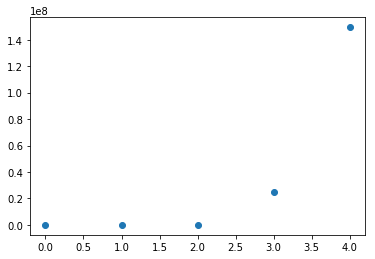

In [3]:
my_comp.apply_neumann_boundaries(2,1e8, 'normal')
K, f = my_comp.assembly_class.assemble_k_and_f()
K_, f = my_comp.assembly_class.assemble_k_and_f_neumann()
M = my_comp.assembly_class.assemble_m()
pd.DataFrame(K.todense())

eigval, eigvec = linalg.eigh(K.todense())

plt.plot(eigval[0:5], 'o')
plt.show()



In [4]:
dirsub = m.get_submesh('phys_group', 1)
dir_nodes = dirsub.global_node_list
id_matrix = my_comp.assembly_class.id_matrix
dir_dofs = []
for node, dof in id_matrix.items():
    if node in dir_nodes:
        dir_dofs.extend(dof)

        
master_sub = m.get_submesh('phys_group', 2)
master_nodes = master_sub.global_node_list
id_matrix = my_comp.assembly_class.id_matrix
master_dofs = []
slave_dofs = []
for node, dof in id_matrix.items():
    if node in master_nodes:
        master_dofs.extend(dof)        
    else:
        slave_dofs.extend(dof)

K, M, f = my_comp.insert_dirichlet_boundary_cond(K,M,f,dir_dofs)

       
    
slave_dofs = list(set(slave_dofs).difference(dir_dofs))
master_dofs.extend(dir_dofs)



omega, V_dynamic = linalg.eig(K.todense(), M.todense())


C:\Users\ndcsi\.conda\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [ ]:
@interact(no_of_modes=(1,17,1))    
def check(no_of_modes=500):
    T, T_local, P, K_local, M_local = my_comp.compute(M, K, master_dofs, slave_dofs, no_of_modes=no_of_modes)

    Mr = T.T.dot(M.todense()).dot(T)
    Kr = T.T.dot(K.todense()).dot(T)
    ff = T.T.dot(f)

    no_of_modes = 10
    
    omega_red, V_dynamic_red = linalg.eig(Kr, Mr)

    omega_global = np.sort(omega)
    omega_red = np.sort(omega_red)

    plt.plot(omega_red, 'o')
    plt.plot(omega_global, 'x')
    plt.show()


interactive(children=(IntSlider(value=17, description='no_of_modes', max=17, min=1), Output()), _dom_classes=(…

In [ ]:
check(2260)

C:\Users\ndcsi\.conda\envs\ndcsi\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\ndcsi\.conda\envs\ndcsi\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:171: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\ndcsi\.conda\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
